In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib
import scipy

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)

# 学習データの作成

In [3]:
from centernet.utils import preprocess_image, get_mask_and_regr
from centernet.utils import CarDataset

img_name = train_list[8]
img_path = PATH + "image_2/" + img_name + ".png"
img = plt.imread(img_path)
img, offset, scale = preprocess_image(img,True)
mask, regr_size, regr_3D, mask_not_suppressed = get_mask_and_regr(img_name, annotations_list, offset, scale)

train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=1)

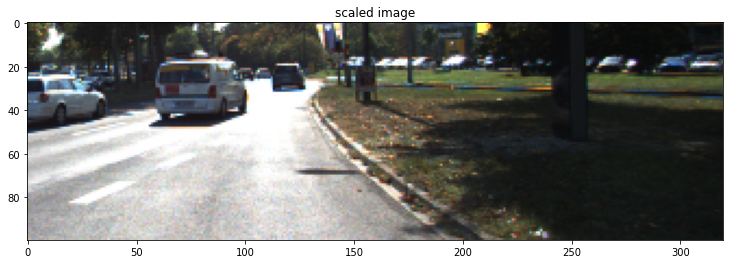

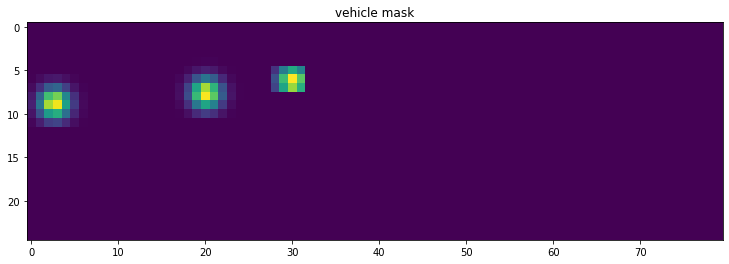

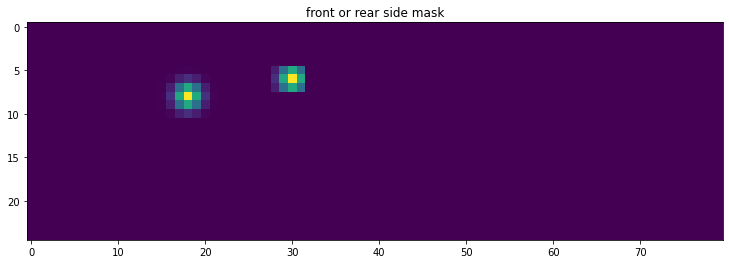

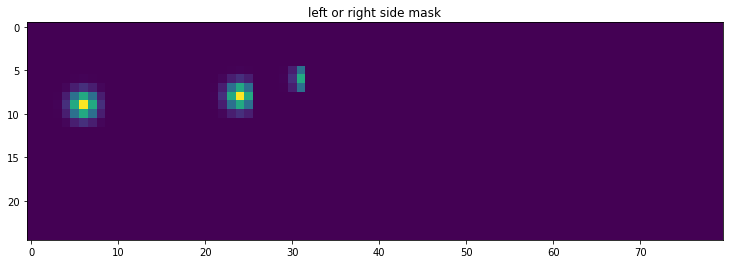

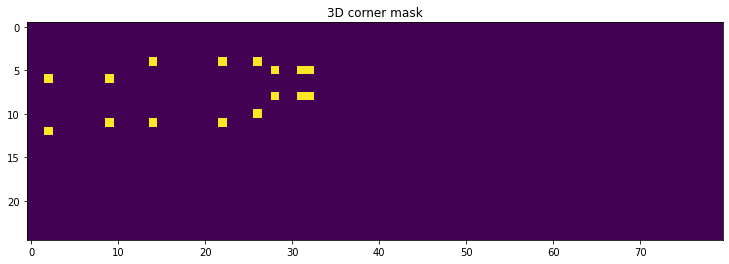

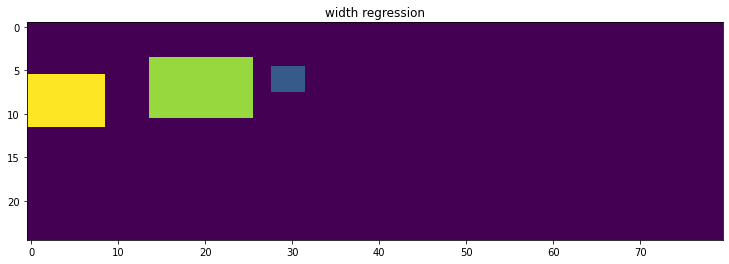

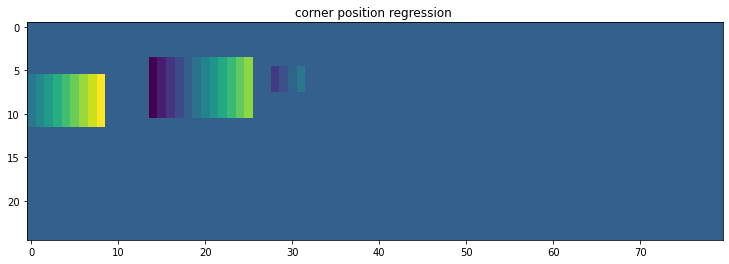

In [4]:
plt.figure(figsize=(15,4))
plt.title('scaled image')
plt.imshow(img)
plt.figure(figsize=(15,4))
plt.title('vehicle mask')
plt.imshow(mask[:,:,0])
plt.figure(figsize=(15,4))
plt.title('front or rear side mask')
plt.imshow(mask[:,:,1])
plt.figure(figsize=(15,4))
plt.title('left or right side mask')
plt.imshow(mask[:,:,2])
plt.figure(figsize=(15,4))
plt.title('3D corner mask')
plt.imshow(mask[:,:,3])
plt.figure(figsize=(15,4))
plt.title('width regression')
plt.imshow(regr_size[:,:,0])
plt.figure(figsize=(15,4))
plt.title('corner position regression ')
plt.imshow(regr_3D[:,:,0])

# モデルの作成

In [5]:
from centernet.models import criterion

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_loss():
    train_mask_loss = 0
    train_regr_size_loss = 0
    train_regr_3D_loss = 0
    
    with torch.no_grad():
        for batch_idx, \
            (img_batch, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)\
                in enumerate(tqdm(train_loader)):
                
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_size_batch = regr_size_batch.to(device)
            regr_3D_batch = regr_3D_batch.to(device)
            mask_not_suppressed_batch = mask_not_suppressed_batch.to(device)
            
            output = np.zeros([img_batch.shape[0],26,mask_batch.shape[2],mask_batch.shape[3]])
            output = torch.tensor(output, device=device)
            mask_loss, regr_size_loss, regr_3D_loss =\
                criterion(output, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)
            
            train_mask_loss += mask_loss.detach()
            train_regr_size_loss += regr_size_loss.detach()
            train_regr_3D_loss += regr_3D_loss.detach()
    
    train_mask_loss /= len(train_list)
    train_regr_size_loss /= len(train_list)
    train_regr_3D_loss /= len(train_list)
    train_loss = train_mask_loss + train_regr_size_loss + train_regr_3D_loss
    
    print('train_mask_loss : ', train_mask_loss.data.cpu().numpy())
    print('train_regr_size_loss : ', train_regr_size_loss.data.cpu().numpy())
    print('train_regr_3D_loss : ', train_regr_3D_loss.data.cpu().numpy())
    print('train_loss : ', train_loss.data.cpu().numpy())

#eval_loss()

### 学習データの確認

In [7]:
#img, mask, regr_size, regr_3D, mask_not_suppressed = train_dataset[2]
#img, mask, regr_size, regr_3D, mask_not_suppressed = train_dataset[6]
#img, mask, regr_size, regr_3D, mask_not_suppressed = train_dataset[8]

#img = np.rollaxis(img, 0, 3)
#mask = np.rollaxis(mask, 0, 3)
#regr_size = np.rollaxis(regr_size, 0, 3)
#regr_3D = np.rollaxis(regr_3D, 0, 3)
#mask_not_suppressed = np.rollaxis(mask_not_suppressed, 0, 3)

In [8]:
from centernet.utils import visualize_heatmap, visualize_2D, visualize_3D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


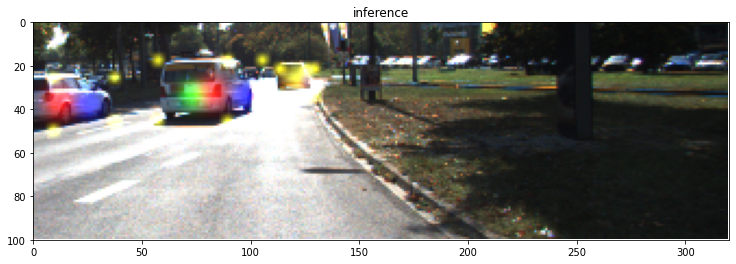

In [9]:
visualize_heatmap(img, mask)

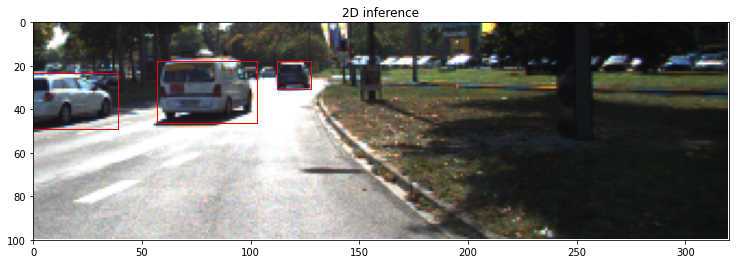

In [10]:
visualize_2D(img, mask, regr_size, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


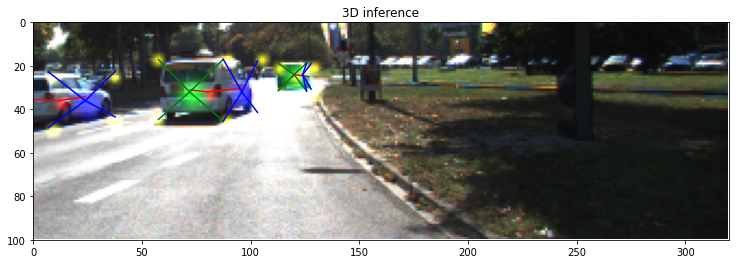

In [11]:
visualize_3D(img, mask, regr_3D, 4)